In [ ]:
!pip install psycopg2-binary --user
import os
os._exit(00)

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import csv, sys, requests
from PIL import Image
import cv2, os, json, re
import joblib, psycopg2
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
DB_NAME = 'rs-stocks'

In [3]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

def rs_fetch_datasets():
    user = os.getenv("DKUBE_USER_LOGIN_NAME")
    url = "http://dkube-controller-worker.dkube:5000/dkube/v2/controller/users/%s/datums/class/dataset/datum/%s"
    headers={"authorization": "Bearer "+os.getenv("DKUBE_USER_ACCESS_TOKEN")}
    datasets = []
    for ds in json.load(open('/etc/dkube/redshift.json')):
        resp = requests.get(url % (user, ds.get('rs_name')), headers=headers).json()
        ds['rs_password'] = resp['data']['datum']['redshift']['password']
        datasets.append(ds)
    return datasets

def get_password(user, db):
    datasets = rs_fetch_datasets()
    for dataset in datasets:
        if dataset.get("rs_user") == user and dataset.get("rs_database") == db:
            return dataset.get("rs_password")
    raise Exception("Failed to find password for DB {} with User {}".format(user, db))

In [4]:
def load_rs_to_csv(usr,passwd, hst, prt, db):
    try:
        connection = psycopg2.connect(user = usr,
       	                              password = passwd,
           	                          host = hst,
               	                      port = prt,
                   	                  database = db)
    except (Exception, psycopg2.Error) as error :
        print("Error while connecting to Redshift", error)

    wf = open('goog.csv', mode='w')
    csv_writer = csv.writer(wf, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(['Date','Open','High','Low','Close','Volume'])

    cursor = connection.cursor()
    cursor.execute("SELECT * from sklearn;")
    record = cursor.fetchall()
    for each in record:
        csv_writer.writerow(each)

In [5]:
def get_data(filename):
    with open(filename, 'r') as csvfile:
        csvFileReader = csv.reader(csvfile)
        next(csvFileReader)    # skipping column names
        for row in csvFileReader:
            dates.append(int(row[0].split('-')[0]))
            prices.append(float(row[1]))
    return

In [6]:
dates = []
prices = []
name = 'SVM for stock Preiction'
kernel = 'rbf'
C = 1e3
gamma = 0.1
degree= 2

In [7]:
for each_db in json.load(open('/etc/dkube/redshift.json')):
    if each_db["rs_name"] == DB_NAME:
        r_endpoint = each_db["rs_endpoint"]
        r_database = each_db["rs_database"]
        r_user = each_db["rs_user"]
r_password = get_password(r_user, r_database)

In [11]:
#r_endpoint, r_database, r_user, r_password

In [12]:
if 'https:' in r_endpoint:
    p = '(?:https*://)?(?P<host>[^:/ ]+).?(?P<port>[0-9]*).*'
    m = re.search(p,r_endpoint)
else:
    p = '(?:http*://)?(?P<host>[^:/ ]+).?(?P<port>[0-9]*).*'
    m = re.search(p,r_endpoint)

load_rs_to_csv(r_user, r_password, m.group('host'), m.group('port'), r_database)

get_data('goog.csv')

## Dataset Visulization

In [13]:
d = {'dates': dates, 'price': prices}
stdata = pd.DataFrame(d)
stdata.head(5)

,dates,price
0,26,708.58
1,25,700.01
2,24,688.92
3,23,701.45
4,22,707.45


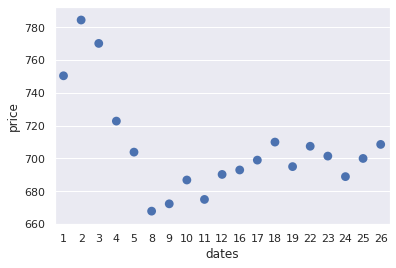

In [14]:
sns.set_style("darkgrid")
sns.pointplot(x='dates', y='price', data=stdata, join=False)

## Fitting data 

In [15]:
dates = np.reshape(dates,(len(dates), 1))

svm = SVR(kernel= kernel, C= C, degree= degree, gamma=gamma)

svm.fit(dates, prices)

predictions = svm.predict(dates)

In [16]:
(rmse, mae, r2) = eval_metrics(prices, predictions)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R2 score: ", r2)

RMSE:  3.745203677890233
MAE:  1.9037466212676966
R2 score:  0.9846989109422634


## Visualising Support Vectors

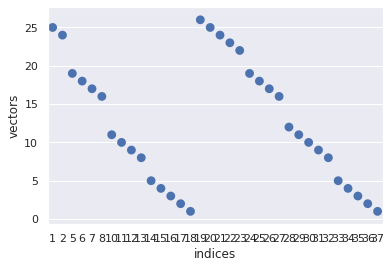

In [17]:
support_vector_indices = svm.support_
support_vectors = svm.support_vectors_
d = {'indices': support_vector_indices, 'vectors': support_vectors.reshape(support_vectors.shape[0])}
vectors = pd.DataFrame(d)
sns.set_style("darkgrid")
sns.pointplot(x='indices', y='vectors', data=vectors, join=False)

## Comparison of predictions with training data

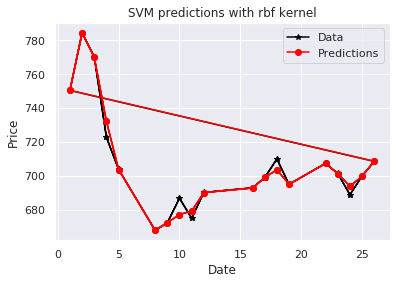

In [18]:
plt.plot(dates, prices, color= 'black', label = 'Data', marker = '*')
plt.plot(dates,predictions, color= 'red', label = "Predictions", marker = 'o')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SVM predictions with '+kernel+ ' kernel')
plt.legend()
plt.show()